<a href="https://colab.research.google.com/github/RhysWangJunfei/nilm/blob/master/pecan_nilm_fre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from datetime import datetime
import os
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,Activation,Dense,Softmax,Input
from tensorflow.keras import Model
from keras.utils import plot_model

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.96.240.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.96.240.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [4]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
with tf.device('/TPU:0'):
  c = tf.matmul(a, b)
print("c device: ", c.device)
print(c)
strategy = tf.distribute.TPUStrategy(resolver)

c device:  /job:worker/replica:0/task:0/device:TPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
stacked_X = pd.read_csv('/content/drive/My Drive/Phd/dataset/pecan_x.csv').values[:,1:]
stacked_y = pd.read_csv('/content/drive/My Drive/Phd/dataset/pecan_y.csv').values[:,1]

In [6]:
'''Sliding window function'''
def create_dataset(dataset, look_back=1):
    dataX = []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
    return np.array(dataX)

def calc_max_time_diff(df):
    time = pd.to_datetime(df['localminute'],format="%Y-%m-%d %H:%M:%S-%f")
    time_diff = time.diff()
    aa = time_diff.dt.total_seconds()
    print(aa.max())
    print(aa.idxmax())
    return
def normalization(dataX):
  min_value=-20000
  max_value=20000
  #mean_value=856
  scaled_dataX = (dataX-min_value)/(max_value-min_value)
  return scaled_dataX


In [7]:
X_test = pd.read_csv('/content/drive/My Drive/Phd/dataset/X_test.csv').values[:,1:]
y_test = pd.read_csv('/content/drive/My Drive/Phd/dataset/y_test.csv').values[:,1:]
X_test_norm = normalization(X_test)

In [8]:
categorized_Y = np.ones(stacked_y.shape)*1
categorized_Y[[np.where(stacked_y<=50)[0]]]=0

df = pd.Series(categorized_Y)
df.value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


0.0    392299
1.0    181392
dtype: int64

In [9]:
X_train, X_vali, y_train, y_vali = train_test_split(stacked_X,categorized_Y,\
            test_size=0.2, shuffle=True)
X_train_norm = normalization(X_train)
X_vali_norm = normalization(X_vali)

In [10]:
df = pd.Series(y_train.flatten())
df.value_counts()

0.0    313932
1.0    145020
dtype: int64

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
y_vali_oh = encoder.fit_transform(y_vali.reshape([-1,1]))
y_test_oh = encoder.fit_transform(y_test.reshape([-1,1]))

In [17]:
'''from tensorflow.keras.layers import BatchNormalization
X_train_norm = normalization(X_train)
X_vali_norm = normalization(X_vali)

model = Sequential()
model.add(LSTM(128, return_sequences=None, input_shape=(60,1)))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(8))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
#plot_model(model, show_shapes=True, to_file='teacher_model.png')
#model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
activation_6 (Activation)    (None, 64)               

In [13]:
model = load_model('/content/drive/MyDrive/Phd/dataset/0107_pecan.h5')

In [14]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_139 (Dense)            (None, 128)               16512     
_________________________________________________________________
activation_111 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_112 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_113 (Activation)  (None, 32)              

In [16]:
from imblearn.under_sampling import RandomUnderSampler
tl = RandomUnderSampler(sampling_strategy={0:130000,1:130000})

for i in range(0,100):
    print('##### Here we go epoch number '+str(i))
    X, y = tl.fit_resample(X_train_norm, y_train)
    y_oh = encoder.fit_transform(y.reshape([-1,1]))
    print(y_oh.shape)
    model.fit(X.reshape([-1,60,1]), y_oh , epochs=1, batch_size=256, shuffle=True,validation_data=(X_vali_norm.reshape([-1,60,1]),y_vali_oh))
#score, acc = model.evaluate(X_test.reshape([-1,60,1]),y_test)
model.save('/content/drive/My Drive/Phd/dataset/01072_pecan.h5')

##### Here we go epoch number 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 171ms/step - loss: 0.2334 - accuracy: 0.9018 - val_loss: 0.2717 - val_accuracy: 0.8897
##### Here we go epoch number 1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2334 - accuracy: 0.9021 - val_loss: 0.2707 - val_accuracy: 0.8901
##### Here we go epoch number 2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2321 - accuracy: 0.9024 - val_loss: 0.2643 - val_accuracy: 0.8933
##### Here we go epoch number 3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2307 - accuracy: 0.9028 - val_loss: 0.2699 - val_accuracy: 0.8903
##### Here we go epoch number 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.2304 - accuracy: 0.9031 - val_loss: 0.2769 - val_accuracy: 0.8882
##### Here we go epoch number 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2317 - accuracy: 0.9027 - val_loss: 0.2557 - val_accuracy: 0.8990
##### Here we go epoch number 6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.2290 - accuracy: 0.9043 - val_loss: 0.2609 - val_accuracy: 0.8951
##### Here we go epoch number 7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2288 - accuracy: 0.9038 - val_loss: 0.2691 - val_accuracy: 0.8918
##### Here we go epoch number 8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2295 - accuracy: 0.9035 - val_loss: 0.2645 - val_accuracy: 0.8927
##### Here we go epoch number 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.2270 - accuracy: 0.9048 - val_loss: 0.2693 - val_accuracy: 0.8910
##### Here we go epoch number 10


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2261 - accuracy: 0.9052 - val_loss: 0.2722 - val_accuracy: 0.8909
##### Here we go epoch number 11


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.2260 - accuracy: 0.9052 - val_loss: 0.2651 - val_accuracy: 0.8940
##### Here we go epoch number 12


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2550 - accuracy: 0.8913 - val_loss: 0.4276 - val_accuracy: 0.8248
##### Here we go epoch number 13


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3854 - accuracy: 0.8217 - val_loss: 0.3490 - val_accuracy: 0.8445
##### Here we go epoch number 14


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3284 - accuracy: 0.8521 - val_loss: 0.3283 - val_accuracy: 0.8568
##### Here we go epoch number 15


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2995 - accuracy: 0.8689 - val_loss: 0.3067 - val_accuracy: 0.8676
##### Here we go epoch number 16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 171ms/step - loss: 0.2805 - accuracy: 0.8789 - val_loss: 0.2870 - val_accuracy: 0.8798
##### Here we go epoch number 17


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2691 - accuracy: 0.8846 - val_loss: 0.2771 - val_accuracy: 0.8833
##### Here we go epoch number 18


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2608 - accuracy: 0.8887 - val_loss: 0.2726 - val_accuracy: 0.8875
##### Here we go epoch number 19


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2525 - accuracy: 0.8929 - val_loss: 0.2689 - val_accuracy: 0.8885
##### Here we go epoch number 20


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2476 - accuracy: 0.8947 - val_loss: 0.2659 - val_accuracy: 0.8911
##### Here we go epoch number 21


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2411 - accuracy: 0.8976 - val_loss: 0.2749 - val_accuracy: 0.8864
##### Here we go epoch number 22


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.2896 - accuracy: 0.8741 - val_loss: 0.5831 - val_accuracy: 0.7725
##### Here we go epoch number 23


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.5198 - accuracy: 0.7540 - val_loss: 0.4694 - val_accuracy: 0.8153
##### Here we go epoch number 24


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.4781 - accuracy: 0.7821 - val_loss: 0.4476 - val_accuracy: 0.8217
##### Here we go epoch number 25


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 177s 173ms/step - loss: 0.4627 - accuracy: 0.7870 - val_loss: 0.4908 - val_accuracy: 0.7964
##### Here we go epoch number 26


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.4504 - accuracy: 0.7903 - val_loss: 0.5497 - val_accuracy: 0.7868
##### Here we go epoch number 27


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.4496 - accuracy: 0.7917 - val_loss: 0.4410 - val_accuracy: 0.8063
##### Here we go epoch number 28


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.4331 - accuracy: 0.7964 - val_loss: 0.4230 - val_accuracy: 0.7979
##### Here we go epoch number 29


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.4282 - accuracy: 0.7988 - val_loss: 0.3844 - val_accuracy: 0.8358
##### Here we go epoch number 30


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.4206 - accuracy: 0.8009 - val_loss: 0.4032 - val_accuracy: 0.8186
##### Here we go epoch number 31


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.4114 - accuracy: 0.8058 - val_loss: 0.4040 - val_accuracy: 0.8206
##### Here we go epoch number 32


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.4108 - accuracy: 0.8071 - val_loss: 0.3805 - val_accuracy: 0.8355
##### Here we go epoch number 33


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.4047 - accuracy: 0.8099 - val_loss: 0.3767 - val_accuracy: 0.8394
##### Here we go epoch number 34


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.4003 - accuracy: 0.8115 - val_loss: 0.3750 - val_accuracy: 0.8301
##### Here we go epoch number 35


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3938 - accuracy: 0.8154 - val_loss: 0.3833 - val_accuracy: 0.8425
##### Here we go epoch number 36


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3932 - accuracy: 0.8156 - val_loss: 0.3733 - val_accuracy: 0.8406
##### Here we go epoch number 37


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3884 - accuracy: 0.8178 - val_loss: 0.3607 - val_accuracy: 0.8447
##### Here we go epoch number 38


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3839 - accuracy: 0.8208 - val_loss: 0.4470 - val_accuracy: 0.7671
##### Here we go epoch number 39


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3825 - accuracy: 0.8216 - val_loss: 0.3600 - val_accuracy: 0.8394
##### Here we go epoch number 40


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.3817 - accuracy: 0.8220 - val_loss: 0.3699 - val_accuracy: 0.8294
##### Here we go epoch number 41


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.3771 - accuracy: 0.8229 - val_loss: 0.3815 - val_accuracy: 0.8292
##### Here we go epoch number 42


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3760 - accuracy: 0.8242 - val_loss: 0.3547 - val_accuracy: 0.8477
##### Here we go epoch number 43


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3718 - accuracy: 0.8266 - val_loss: 0.4086 - val_accuracy: 0.8013
##### Here we go epoch number 44


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3706 - accuracy: 0.8265 - val_loss: 0.3668 - val_accuracy: 0.8447
##### Here we go epoch number 45


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3699 - accuracy: 0.8274 - val_loss: 0.3496 - val_accuracy: 0.8446
##### Here we go epoch number 46


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 171ms/step - loss: 0.3666 - accuracy: 0.8287 - val_loss: 0.3589 - val_accuracy: 0.8413
##### Here we go epoch number 47


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3635 - accuracy: 0.8309 - val_loss: 0.3812 - val_accuracy: 0.8191
##### Here we go epoch number 48


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3652 - accuracy: 0.8296 - val_loss: 0.3577 - val_accuracy: 0.8394
##### Here we go epoch number 49


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.3627 - accuracy: 0.8309 - val_loss: 0.3759 - val_accuracy: 0.8211
##### Here we go epoch number 50


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3575 - accuracy: 0.8334 - val_loss: 0.3371 - val_accuracy: 0.8522
##### Here we go epoch number 51


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.3562 - accuracy: 0.8338 - val_loss: 0.3432 - val_accuracy: 0.8467
##### Here we go epoch number 52


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 177s 174ms/step - loss: 0.3546 - accuracy: 0.8348 - val_loss: 0.3543 - val_accuracy: 0.8466
##### Here we go epoch number 53


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3537 - accuracy: 0.8349 - val_loss: 0.4076 - val_accuracy: 0.8148
##### Here we go epoch number 54


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3512 - accuracy: 0.8361 - val_loss: 0.3422 - val_accuracy: 0.8470
##### Here we go epoch number 55


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3481 - accuracy: 0.8383 - val_loss: 0.3419 - val_accuracy: 0.8518
##### Here we go epoch number 56


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3455 - accuracy: 0.8398 - val_loss: 0.3428 - val_accuracy: 0.8551
##### Here we go epoch number 57


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3461 - accuracy: 0.8396 - val_loss: 0.3394 - val_accuracy: 0.8501
##### Here we go epoch number 58


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3432 - accuracy: 0.8415 - val_loss: 0.3683 - val_accuracy: 0.8298
##### Here we go epoch number 59


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.3421 - accuracy: 0.8414 - val_loss: 0.3399 - val_accuracy: 0.8531
##### Here we go epoch number 60


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3414 - accuracy: 0.8428 - val_loss: 0.3574 - val_accuracy: 0.8289
##### Here we go epoch number 61


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3409 - accuracy: 0.8426 - val_loss: 0.3261 - val_accuracy: 0.8551
##### Here we go epoch number 62


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3394 - accuracy: 0.8441 - val_loss: 0.3294 - val_accuracy: 0.8555
##### Here we go epoch number 63


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3348 - accuracy: 0.8460 - val_loss: 0.3526 - val_accuracy: 0.8403
##### Here we go epoch number 64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3341 - accuracy: 0.8469 - val_loss: 0.3299 - val_accuracy: 0.8534
##### Here we go epoch number 65


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 172ms/step - loss: 0.3333 - accuracy: 0.8474 - val_loss: 0.3529 - val_accuracy: 0.8459
##### Here we go epoch number 66


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3317 - accuracy: 0.8484 - val_loss: 0.3398 - val_accuracy: 0.8478
##### Here we go epoch number 67


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3301 - accuracy: 0.8483 - val_loss: 0.3396 - val_accuracy: 0.8540
##### Here we go epoch number 68


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 177s 173ms/step - loss: 0.3279 - accuracy: 0.8503 - val_loss: 0.3256 - val_accuracy: 0.8552
##### Here we go epoch number 69


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3273 - accuracy: 0.8501 - val_loss: 0.3210 - val_accuracy: 0.8569
##### Here we go epoch number 70


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3259 - accuracy: 0.8514 - val_loss: 0.3388 - val_accuracy: 0.8530
##### Here we go epoch number 71


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3246 - accuracy: 0.8522 - val_loss: 0.3302 - val_accuracy: 0.8543
##### Here we go epoch number 72


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3234 - accuracy: 0.8537 - val_loss: 0.3258 - val_accuracy: 0.8596
##### Here we go epoch number 73


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 177s 173ms/step - loss: 0.3205 - accuracy: 0.8544 - val_loss: 0.3161 - val_accuracy: 0.8629
##### Here we go epoch number 74


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3200 - accuracy: 0.8555 - val_loss: 0.3135 - val_accuracy: 0.8644
##### Here we go epoch number 75


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3191 - accuracy: 0.8555 - val_loss: 0.3083 - val_accuracy: 0.8675
##### Here we go epoch number 76


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3175 - accuracy: 0.8561 - val_loss: 0.3156 - val_accuracy: 0.8621
##### Here we go epoch number 77


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3139 - accuracy: 0.8591 - val_loss: 0.3654 - val_accuracy: 0.8339
##### Here we go epoch number 78


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3165 - accuracy: 0.8574 - val_loss: 0.3196 - val_accuracy: 0.8639
##### Here we go epoch number 79


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3127 - accuracy: 0.8594 - val_loss: 0.3167 - val_accuracy: 0.8665
##### Here we go epoch number 80


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 176s 173ms/step - loss: 0.3117 - accuracy: 0.8602 - val_loss: 0.3260 - val_accuracy: 0.8576
##### Here we go epoch number 81


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
1016/1016 [==============================] - 175s 172ms/step - loss: 0.3084 - accuracy: 0.8616 - val_loss: 0.3142 - val_accuracy: 0.8675
##### Here we go epoch number 82


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(260000, 2)
 818/1016 [=======================>......] - ETA: 28s - loss: 0.3087 - accuracy: 0.8623

KeyboardInterrupt: ignored

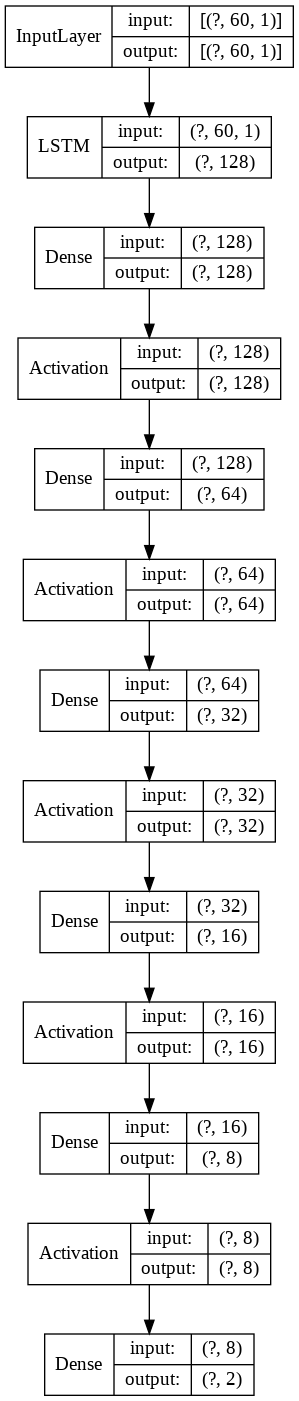

In [ ]:
from tensorflow.keras.utils import plot_model
model = load_model('/content/drive/My Drive/Phd/dataset/0513_nilm85_pecan.h5')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
#score, acc = model.evaluate(X_test_norm.reshape([-1,60]),y_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
pred = model.predict_classes(X_test_norm.reshape([-1,60,1]))
#nilm_pred = nilm_model.predict_classes(X_test_norm.reshape([-1,60,1]))
matrix = confusion_matrix(y_test, pred)
score = accuracy_score(y_test, pred)
print(matrix)
print(score)

[[35275  4782]
 [ 3562 13751]]
0.8545581314275754
